0. Install and Import Dependencies

In [147]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio


In [148]:
tf.config.list_physical_devices('GPU')

[]

In [149]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

1. Build Data Loading Functions

In [150]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[ 315:385,300:440,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [151]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [152]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [153]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [154]:
char_to_num(['n','e','i','1'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  5,  9, 30])>

In [155]:
num_to_char([14,  5,  9, 30])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'e', b'i', b'1'], dtype=object)>

In [156]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [157]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data_cantonese','s1',f'{file_name}.mp4')
    alignment_path = os.path.join('data_cantonese','alignment','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [158]:
test_path = './data_cantonese/s1/IMG_8806.mp4'

In [159]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'IMG_8806'

In [160]:
tf.convert_to_tensor(test_path)

<tf.Tensor: shape=(), dtype=string, numpy=b'./data_cantonese/s1/IMG_8806.mp4'>

In [161]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [162]:
load_data(tf.convert_to_tensor(test_path))

(<tf.Tensor: shape=(75, 70, 140, 1), dtype=float32, numpy=
 array([[[[ 0.7081111 ],
          [ 0.59009254],
          [ 0.55075306],
          ...,
          [ 1.4949012 ],
          [ 1.5342407 ],
          [ 1.5342407 ]],
 
         [[ 0.7081111 ],
          [ 0.59009254],
          [ 0.55075306],
          ...,
          [ 1.4949012 ],
          [ 1.4949012 ],
          [ 1.5342407 ]],
 
         [[ 0.7081111 ],
          [ 0.59009254],
          [ 0.59009254],
          ...,
          [ 1.3768827 ],
          [ 1.3768827 ],
          [ 1.4162222 ]],
 
         ...,
 
         [[10.031573  ],
          [10.031573  ],
          [10.031573  ],
          ...,
          [ 0.15735802],
          [ 0.19669752],
          [ 0.19669752]],
 
         [[ 0.        ],
          [ 0.        ],
          [10.031573  ],
          ...,
          [ 0.15735802],
          [ 0.15735802],
          [ 0.19669752]],
 
         [[ 0.        ],
          [ 0.        ],
          [ 0.        ],
          

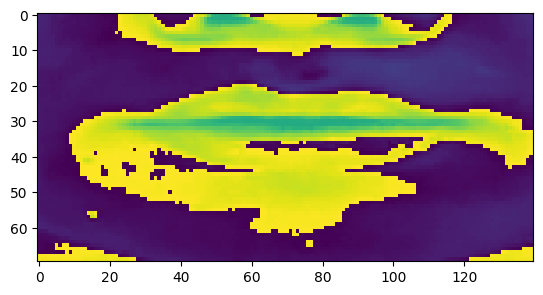

In [163]:
plt.imshow(frames[70])

In [164]:
alignments

<tf.Tensor: shape=(14,), dtype=int64, numpy=array([26,  1,  1, 14, 35, 39,  8, 15, 21, 31, 39,  4, 15, 30])>

In [165]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'zaan6 hou2 do1'>

In [166]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

2. Create Data Pipeline

In [167]:
from matplotlib import pyplot as plt

In [219]:
data = tf.data.Dataset.list_files('./data_cantonese/s1/*.mp4')
data = data.shuffle(100, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([90,None,None,None],[20]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
# Determine the sizes for training and testing sets
total_samples = 300
train_size = int(0.8 * total_samples)

# Split the data
train_data = data.take(train_size)
test_data = data.skip(train_size)

In [169]:
# for frames, target_sequence in data:
#     print("Target Sequence Length:", tf.shape(target_sequence)[1])


In [170]:
for sample in data.take(5):  # Adjust the number of samples to print
    video_frames, label = sample
    print("Video Frames Shape:", video_frames.shape)
    print("Label:", label.numpy())
    print("~" * 50)

Video Frames Shape: (2, 90, 70, 140, 1)
Label: [[ 8 15 21 31 39  7  5 14  7 30 39  8  5  9 31  0  0  0  0  0]
 [ 8 15 21 31 39  7  1 13 31 39 26  5 35  0  0  0  0  0  0  0]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Video Frames Shape: (2, 90, 70, 140, 1)
Label: [[15  9 32 39 14  5  9 34 39  4  5  9 35  0  0  0  0  0  0  0]
 [ 8 15 21 31 39  4  1 11 30 39 10  9 32  0  0  0  0  0  0  0]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Video Frames Shape: (2, 90, 70, 140, 1)
Label: [[ 8 15 21 31 39  8  9 14  7 30 39  6  1 14 34  0  0  0  0  0]
 [26 15  9 32 39  7  9 14 32 39 12  1  1 30  0  0  0  0  0  0]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Video Frames Shape: (2, 90, 70, 140, 1)
Label: [[14  7  1 13 30 39 14  7  1 13 30 39 12  5  9 33  0  0  0  0]
 [26 15 21 31 39 20 15 21 31 39  1  1 32  0  0  0  0  0  0  0]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Video Frames Shape: (2, 90, 70, 140, 1)
Label: [[ 8 15  9 30 39 19  1 13 30 39 15 30  0  0  0  0  0 

In [172]:
# Assuming `data` is your dataset
print("Element Spec:")
print(data.element_spec)

# Access the padded_shapes attribute for each element
for element_spec in data.element_spec:
    if isinstance(element_spec, tuple) and len(element_spec) == 2:
        print("Padded Shape:", element_spec[1])


Element Spec:
(TensorSpec(shape=(None, 90, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.int64, name=None))


In [173]:
frames, alignments = data.as_numpy_iterator().next()

In [174]:
data.as_numpy_iterator().next()

(array([[[[[ 0.3977839 ],
           [ 0.3977839 ],
           [ 0.2531352 ],
           ...,
           [ 1.3741626 ],
           [ 1.4103247 ],
           [ 1.4103247 ]],
 
          [[ 0.3977839 ],
           [ 0.3977839 ],
           [ 0.2531352 ],
           ...,
           [ 1.3380004 ],
           [ 1.3741626 ],
           [ 1.4103247 ]],
 
          [[ 0.3977839 ],
           [ 0.3977839 ],
           [ 0.2531352 ],
           ...,
           [ 1.3018382 ],
           [ 1.3380004 ],
           [ 1.3380004 ]],
 
          ...,
 
          [[ 0.        ],
           [ 0.03616217],
           [ 0.03616217],
           ...,
           [ 0.18081087],
           [ 0.21697304],
           [ 0.28929737]],
 
          [[ 9.185192  ],
           [ 0.        ],
           [ 0.        ],
           ...,
           [ 0.18081087],
           [ 0.21697304],
           [ 0.28929737]],
 
          [[ 9.185192  ],
           [ 9.185192  ],
           [ 9.185192  ],
           ...,
           [ 0

In [175]:
len(frames)

2

In [176]:
sample = data.as_numpy_iterator()

In [177]:
val = sample.next(); val[0]

array([[[[[ 0.72855484],
          [ 0.72855484],
          [ 0.72855484],
          ...,
          [ 0.72855484],
          [ 0.72855484],
          [ 0.7845975 ]],

         [[ 0.7845975 ],
          [ 0.7845975 ],
          [ 0.72855484],
          ...,
          [ 0.6725121 ],
          [ 0.72855484],
          [ 0.7845975 ]],

         [[ 0.89668286],
          [ 0.8406402 ],
          [ 0.72855484],
          ...,
          [ 0.5604268 ],
          [ 0.6725121 ],
          [ 0.72855484]],

         ...,

         [[ 0.44834143],
          [ 0.39229876],
          [ 0.39229876],
          ...,
          [13.954627  ],
          [13.954627  ],
          [14.01067   ]],

         [[ 0.44834143],
          [ 0.39229876],
          [ 0.33625606],
          ...,
          [13.954627  ],
          [13.954627  ],
          [14.01067   ]],

         [[ 0.5043841 ],
          [ 0.33625606],
          [ 0.2802134 ],
          ...,
          [13.954627  ],
          [14.01067   ],
          

In [178]:
len(val[0])

2

In [179]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

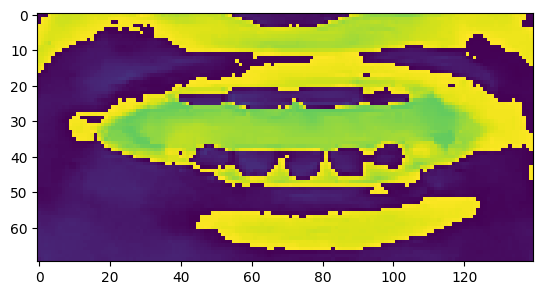

In [180]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][30])

In [181]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'ze6 bong1 sau2'>

3.Design the Deep Neural Network

In [182]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [183]:
data.as_numpy_iterator().next()[0][0].shape

(90, 70, 140, 1)

In [185]:
def create_lip_reading_model(input_shape, num_classes):
    model = Sequential()
    
    # model.add(Masking(mask_value=0.0, input_shape=input_shape))
    model.add(Conv3D(128, 3, input_shape=input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1, 2, 2)))

    model.add(Conv3D(256, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1, 2, 2)))

    model.add(Conv3D(70, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1, 2, 2)))

    model.add(TimeDistributed(Flatten()))

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, kernel_initializer='he_normal', activation='softmax'))

    return model


In [186]:
input_shape = (90,70,140,1)  # Modify based on actual input shape
num_classes =  char_to_num.vocabulary_size()+1 # Replace with the actual number of classes

In [187]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [188]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
# Print shapes for debugging
    # tf.print("y_true shape:", batch_len)
    # tf.print("y_pred shape:", input_length)

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [189]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        # Get the next batch of data from the dataset
        data = self.dataset.next()
        # Make predictions using the trained model
        yhat = self.model.predict(data[0])
        # Decode the predicted sequences using CTC decoding
        decoded = tf.keras.backend.ctc_decode(yhat, [90,90], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [205]:
from tensorflow.keras.models import load_model
custom_objects = {'CTCLoss': CTCLoss}
checkpoint_directory = './saved_models'
# Ensure the checkpoint directory exists; if not, create it
os.makedirs(checkpoint_directory, exist_ok=True)
# Specify the checkpoint file path
checkpoint_path = os.path.join(checkpoint_directory, 'checkpoint')
# Check if there is a checkpoint file
if os.path.exists(checkpoint_path):
    print("Checkpoint exists in models.")
    # model = create_lip_reading_model(input_shape, num_classes)
    model = load_model(checkpoint_path,  custom_objects=custom_objects)
     # Retrieve the last epoch from the training history
    last_epoch = max(model.history.epoch) + 1 if hasattr(model.history, 'epoch') else 1
    # model.load_weights(checkpoint_path)
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                    loss=CTCLoss)
    checkpoint_callback = ModelCheckpoint(
    os.path.join('saved_models','checkpoint'),
    monitor='loss', 
    save_weights_only=False, 
    save_freq='epoch', 
    save_format='h5') 
    print(f"Model loaded from checkpoint. Continue training from epoch {last_epoch}.")
    schedule_callback = LearningRateScheduler(scheduler)
    example_callback = ProduceExample(test_data)
    model.fit(train_data, validation_data=test_data, epochs=50, 
              callbacks=[checkpoint_callback, schedule_callback, example_callback],
              initial_epoch=last_epoch)
else:
    # If there is no checkpoint, create a new model
    # input_shape = (100, 100, 720, 1)  # Modify based on your actual input shape
    # num_classes =  char_to_num.vocabulary_size()+1 # Replace with the actual number of classes
    model = create_lip_reading_model(input_shape, num_classes)
    print("No checkpoint found. Creating a new model.")


No checkpoint found. Creating a new model.


In [206]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 90, 70, 140, 128   3584      
                             )                                   
                                                                 
 activation_15 (Activation)  (None, 90, 70, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_15 (MaxPooli  (None, 90, 35, 70, 128)   0         
 ng3D)                                                           
                                                                 
 conv3d_16 (Conv3D)          (None, 90, 35, 70, 256)   884992    
                                                                 
 activation_16 (Activation)  (None, 90, 35, 70, 256)   0         
                                                      

In [207]:
yhat = model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [208]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'76iiiiiiiiii         p                                8     333888333388888888888999999999'>

In [209]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'76iiiiiiiiii         p                                8     333888333388888888888999999999'>

In [210]:
model.input_shape

(None, 90, 70, 140, 1)

In [211]:
model.output_shape

(None, 90, 41)

In [212]:
# from tensorflow.keras.utils import plot_model

# # Assuming 'model' is your neural network
# plot_model(model, to_file='model_network.png', show_shapes=True, show_layer_names=True)


4. Setup Training Options and Train

In [213]:
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
, loss=CTCLoss)

In [214]:
# print("Number of sequences in the batch:", batch_len.numpy())

In [215]:
checkpoint_callback = ModelCheckpoint(
    os.path.join('saved_models','checkpoint'),
    monitor='loss', 
    save_weights_only=False, 
    save_freq='epoch', 
    save_format='h5') 

In [216]:
schedule_callback = LearningRateScheduler(scheduler)

In [217]:
example_callback = ProduceExample(test_data)

In [218]:
model.fit(train_data, validation_data=test_data, epochs=50, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/50
64/64 [==============================] - ETA: 0s - loss: 88.0834 INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 5s 5s/step
Original: deoi3 m4 zyu6
Prediction:  a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 gam2 dung6
Prediction:  a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 1694s 26s/step - loss: 88.0834 - val_loss: 60.0095 - lr: 1.0000e-04
Epoch 2/50
64/64 [==============================] - ETA: 0s - loss: 57.1647 INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 4s 4s/step
Original: bong1 hou2 jan4
Prediction:  a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: mou4 man6 tai4
Prediction:  a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 1793s 28s/step - loss: 57.1647 - val_loss: 52.1809 - lr: 1.0000e-04
Epoch 3/50
64/64 [==============================] - ETA: 0s - loss: 52.7247 INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 4s 4s/step
Original: seon6 lei6 di1
Prediction:  a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hoi1 sam1 ge3
Prediction:  a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 1697s 26s/step - loss: 52.7247 - val_loss: 49.4421 - lr: 1.0000e-04
Epoch 4/50
64/64 [==============================] - ETA: 0s - loss: 50.7273 INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 4s 4s/step
Original: hing1 fan5 aa3
Prediction:  a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: ngo5 oi3 nei5
Prediction:  a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 1769s 28s/step - loss: 50.7273 - val_loss: 46.5925 - lr: 1.0000e-04
Epoch 5/50
64/64 [==============================] - ETA: 0s - loss: 49.3791 INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 5s 5s/step
Original: faai3 lok6 siu3
Prediction:  a a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hoi1 sam1 lei4
Prediction:  a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 1767s 28s/step - loss: 49.3791 - val_loss: 47.6947 - lr: 1.0000e-04
Epoch 6/50
64/64 [==============================] - ETA: 0s - loss: 48.6487 INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 5s 5s/step
Original: do1 ze6 nei5
Prediction:  a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zan1 hai6 ge3
Prediction:  a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 1987s 31s/step - loss: 48.6487 - val_loss: 46.4047 - lr: 1.0000e-04
Epoch 7/50
64/64 [==============================] - ETA: 0s - loss: 47.9525 INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 4s 4s/step
Original: zoi3 gin3 laa1
Prediction: o a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: dak1 ji3 aa3
Prediction: o a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 1852s 29s/step - loss: 47.9525 - val_loss: 43.9612 - lr: 1.0000e-04
Epoch 8/50
64/64 [==============================] - ETA: 0s - loss: 47.1491 INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 4s 4s/step
Original: faai3 di1 laa1
Prediction: o a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: waan4 dak1 hoi1
Prediction: o a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 1622s 25s/step - loss: 47.1491 - val_loss: 44.8537 - lr: 1.0000e-04
Epoch 9/50
64/64 [==============================] - ETA: 0s - loss: 46.9782 INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 4s 4s/step
Original: nei5 hou2 maa3
Prediction: o a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: ze6 ze6 nei5
Prediction: oa a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 1601s 25s/step - loss: 46.9782 - val_loss: 42.6084 - lr: 1.0000e-04
Epoch 10/50
64/64 [==============================] - ETA: 0s - loss: 45.7171 INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 4s 4s/step
Original: hou2 geng1 hei2
Prediction: o a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: nei5 hou2 maa3
Prediction: oa a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 1580s 25s/step - loss: 45.7171 - val_loss: 45.6856 - lr: 1.0000e-04
Epoch 11/50
64/64 [==============================] - ETA: 0s - loss: 45.6843 INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 3s 3s/step
Original: hou2 dak1 ji3
Prediction: ho a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: oi3 nei5 do1
Prediction: o a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 1571s 25s/step - loss: 45.6843 - val_loss: 44.4860 - lr: 1.0000e-04
Epoch 12/50
64/64 [==============================] - ETA: 0s - loss: 44.3575 INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 3s 3s/step
Original: hou2 dak1 ji3
Prediction: ho a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hoi1 sam1 ge3
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 1566s 24s/step - loss: 44.3575 - val_loss: 41.8726 - lr: 1.0000e-04
Epoch 13/50
64/64 [==============================] - ETA: 0s - loss: 44.5909 INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 3s 3s/step
Original: hou2 hoi1 sam1
Prediction: oa a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: oi3 cing4 tim4
Prediction: oa a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 1568s 24s/step - loss: 44.5909 - val_loss: 42.9489 - lr: 1.0000e-04
Epoch 14/50
64/64 [==============================] - ETA: 0s - loss: 44.3088 INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 4s 4s/step
Original: jau5 mou5 man6
Prediction: ho a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: mou5 sik6 gwo3
Prediction: ho a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 1595s 25s/step - loss: 44.3088 - val_loss: 40.4906 - lr: 1.0000e-04
Epoch 15/50
64/64 [==============================] - ETA: 0s - loss: 43.9971 INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 3s 3s/step
Original: faai3 di1 laa1
Prediction: ho a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: ngam1 ngam1 lei4
Prediction: ho a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 1548s 24s/step - loss: 43.9971 - val_loss: 42.4283 - lr: 1.0000e-04
Epoch 16/50
64/64 [==============================] - ETA: 0s - loss: 43.5429 INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 3s 3s/step
Original: zou2 tou2 aa3
Prediction: o a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zan1 hai6 hou2
Prediction: o a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 1561s 24s/step - loss: 43.5429 - val_loss: 42.5629 - lr: 1.0000e-04
Epoch 17/50
64/64 [==============================] - ETA: 0s - loss: 43.4950 INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


StopIteration: 